#Predicción de irradiación solar

La producción de energía fotovoltaica depende en gran medida de las condiciones climáticas, como la radiación solar y la temperatura. Por lo tanto, los niveles de producción de esta fuente de energía fluctúan, lo cual dificulta que las compañías eléctricas equilibren la producción y el consumo de electricidad cuando utilizan sistemas fotovoltaicos. Por lo tanto, antes de pronosticar la potencia de los sistemas solares, es **esencial la predicción de la irradiación solar.**



#Metodología

![metodologia](https://drive.google.com/uc?export=view&id=1WTCNJ3kc3wT_erNxbgNbR_gCJbfP5DbS)

#Redes neuronales para predicción de series de tiempo

Los algoritmos de predicción de series temporales encuentran **patrones de comportamiento** en el tiempo.

Las **Redes Neuronales Artificiales (RNA)** son los métodos de predicción de irradiación solar más utilizados. El amplio uso de las **RNA** puede explicarse por la mejora de la capacidad de cálculo, la gran disponibilidad de almacenamiento y la mejora de la precisión conseguida por diferentes **arquitecturas de RNA**. Alrededor del **79%** de los métodos utilizados en la previsión meteorológica se basan en redes neuronales y se han desarrollado **estructuras de redes neuronales especializadas** para series temporales.

#Red neuronal recurrente (RNN)
![RNN](https://drive.google.com/uc?export=view&id=1Ysx4DH5NQGiHxBc-M15l4EDhocq9APD0)

Las RNN son una clase de redes que pueden trabajar con secuencias de datos de longitud arbitraria para predecir resultados futuros o clasificar eventos. Esto se hace infiriendo relaciones entre las entrada a través de sus conexiones que apuntan hacia atrás. Cada neurona en una capa RNN recibe un elemento de la entrada en la posición acutal, así como la salida de la predicción anterior (estado oculto) que se basó en el último elemento analizado. Esta estructura implica que las RNN permiten tener en cuenta la información histórica para realizar una siguiente predicción. El principal problema de este tipo de redes es la dificultad de acceder a información de mucho tiempo atrás debido al problema de "Vanishing Gradient".

#Redes neuronales tipo Long short-term memory (LSTM)

![LSTM_cell](https://drive.google.com/uc?export=view&id=1WDy1qDWeKComIEM4Li5ApaJBqHw3bMf7)

las redes LSTM son un tipo especial de RNN que es capaces de aprender dependencias a largo plazo. Recuerda información por largos periodos de tiempo debido a una celda de memoria que almacena información previa, cell state, la cual se actualiza por medio de Gates o compuertas. Estas compuertas se analiza a continuación:

1. Forget Gate: esta compuerta se encarga de indicarle a la celda que debe olvidar información que ha recopilado anteriormente. Lo hace sumando la multiplicación del hidden state anterior y el input actual por unos pesos y pasándolo por una función sigmoide. Esta sigmoide tendrá un valor de 0 o 1 y luego será multiplicada por el cell state para olvidar valores pasados (0) o mantenerlos (1).
 
2. Update Gate/ Input Gate: esta compuerta se encarga de determinar cuanta información recopilada acutalmente será ingresada a la memoria (cell state) y su importancia. Primero la suma del hidden state y el input son pasados por una función sigmoide encargada de determinar si la información actual es útil para el cell state o no. A su vez, una tanh se encarga de darle un peso o nivel de importancia a la información actual (un valor entre -1 y 1). Esta información luego es multiplicada por el valor obtenido por la sigmoide y sumado al cell state.

3. Output Gate: Esta compuerta se encarga de determinar que parte de la información actual pasa al output y a la siguiente celda. Como vemos, otra sigmoide se encarga de determinar qué información pasa y una tanh se encarga de darle la importancia necesaria a los valores almacenados acutalmente en el cell state.

Una visualización de como las LSTM solucionan el problema de vanishing gradients se puede observar en este link:

https://distill.pub/2019/memorization-in-rnns/

#Arquitectura tipo codificador-decodificador (Encoder-Decoder)

![encoder_decoder](https://drive.google.com/uc?export=view&id=1zfM6mz_plpHST2wHHD5nUB8IGQnkgxWr)

El codificador crea una representación interna C. El decodificador transforma C en el vector de salida correspondiente.

#Secciones

[1. Importar librerías](#import_librerias)

[2. Cargar bases de datos](#cargar_datos)

[3. Modelo de predicción](#modelos)

[4. Retos](#retos)

<a name="import_librerias"></a>
#1. Importar librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [ ]:
import tensorflow as tf
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from time import time
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

<a name="cargar_datos"></a>
#2. Cargar bases de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


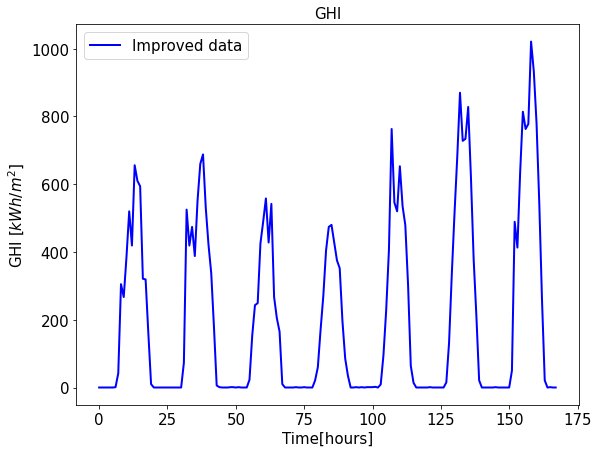

In [ ]:
GHI = pd.read_csv('/content/drive/MyDrive/ML in PV systems/Forecasting/GHI_sa.csv')

plt.figure()
plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(GHI[0:24*7],'b', label='Improved data', linewidth=2)
plt.legend(loc='best', fontsize=15)
plt.xlabel("Time[hours]", fontsize=15)
plt.xticks(size=15)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=15)
plt.title('GHI', fontsize=15)
plt.yticks(size=15)
# plt.savefig('/figure.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
GHI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175200 entries, 0 to 175199
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       175200 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB


<a name="modelos"></a>
#3. Forecasting

## 3.1 Preprocesamiento
Para esta primera sección, realizaremos el preprocesamiento de los datos en donde dividiremos los datos en batches de entrenamiento, testing y validación de los resultados. A su vez, estandarizamos los datos, esto implica que los datos ahora tendrán una media de cero y una varianza de 1.

In [ ]:
# dividir el vector de entrada en muestras
split_time_training = 122640 # esto define el número de muestras que son utilizadas para el entrenamiento
split_time_validation = 148920 # esto define el número de muestras que son utilizadas para la validación (split_time_validation-split_time_traininig), a su vez termina de definir el número de muestras utilizadas en validación
x = np.array(GHI) # Debemos definir un vector con 

scaler = StandardScaler()
scaler = scaler.fit(x.reshape(-1,1))
x = scaler.transform(x.reshape(-1,1)) # aquí realizamos la normalización de los datos.


x_train = x[:split_time_training]
x_valid = x[split_time_training:split_time_validation]
x_test = x[split_time_validation:]


def windowed_dataset(series, n_steps_in_d, n_steps_out_d,  batch_size, shuffle_buffer):
    #series = tf.expand_dims(series, axis = -1)
    #print(series)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(n_steps_in_d + n_steps_out_d, shift=1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(n_steps_in_d + n_steps_out_d))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[0:n_steps_in_d], w[n_steps_in_d:]))
    
    return ds.batch(batch_size).prefetch(1)

n_steps_in_d = 168 # número de muestras utilizadas como entrada de las redes
n_steps_out_d = 24 # número de muestras utilizadas como salida de la red (el número de muestras que buscamos predecir)
batch_size = 128 # Con este número de muestras se realiza cada mini-step del entreno
shuffle_buffer_size = 1000 # Este número afecta la selección aleatoria de los datos. Principalmente es utilizado cuando en memoria no podemos almacenar todas las muestras al tiempo.


train_set = windowed_dataset(x_train, n_steps_in_d, n_steps_out_d, batch_size = batch_size, shuffle_buffer = shuffle_buffer_size)

validation_set = windowed_dataset(x_valid, n_steps_in_d, n_steps_out_d, batch_size = batch_size, shuffle_buffer = shuffle_buffer_size)

test_set = windowed_dataset(x_test, n_steps_in_d, n_steps_out_d, batch_size = batch_size, shuffle_buffer = shuffle_buffer_size)

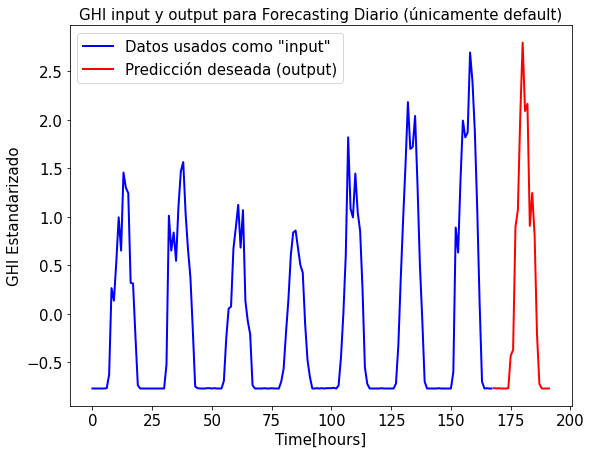

In [ ]:
plt.figure()
plt.rcParams['figure.figsize'] = (9, 7)

plt.plot(x_train[0:n_steps_in_d],'b', label='Datos usados como "input"', linewidth=2)
plt.plot([i for i in range(n_steps_in_d,n_steps_in_d+n_steps_out_d)],x_train[n_steps_in_d:n_steps_in_d+n_steps_out_d],'r', label='Predicción deseada (output)', linewidth=2)
plt.legend(loc='best', fontsize=15)
plt.xlabel("Time[hours]", fontsize=15)
plt.xticks(size=15)
plt.ylabel("GHI Estandarizado", fontsize=15)
plt.title('GHI input y output para Forecasting Diario (únicamente default)', fontsize=15)
plt.yticks(size=15)
# plt.savefig('/figure.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
counter = 0
for i, element in tqdm(enumerate(train_set.as_numpy_iterator())):
    counter = counter + 1
print("\n You generated {} batches of size {} ".format(counter, batch_size))
print('Your training dataset is then composed of around {} sequences'.format(counter*batch_size))

957it [00:50, 19.06it/s]


 You generated 957 batches of size 128 
Your training dataset is then composed of around 122496 sequences


## 3.2 Forecasting Diario

###3.2.1 Entrenando model: Encoder/decoder
El modelo que utilizaremos tiene una arquitectura tipo encoder/decoder, la primera capa consiste en una LSTM que se encarga de 

In [ ]:
# definir el modelo

# encoder
model_d = Sequential()
model_d.add(LSTM(5, input_shape=(n_steps_in_d, 1)))
model_d.add(RepeatVector(n_steps_out_d))

# decoder
model_d.add(LSTM(5, return_sequences=True))
model_d.add(TimeDistributed(Dense(1)))

model_d.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 5)                 140       
                                                                 
 repeat_vector_5 (RepeatVect  (None, 24, 5)            0         
 or)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 24, 5)             220       
                                                                 
 time_distributed_3 (TimeDis  (None, 24, 1)            6         
 tributed)                                                       
                                                                 
Total params: 366
Trainable params: 366
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model_d.compile(loss='mse', optimizer='adam', metrics='mae')

#train the model
start = time()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model_d.fit(train_set, epochs=5, validation_data=validation_set, verbose=1, callbacks=[early_stopping])
print("The model took {} seconds for training.".format(time() - start)) 

Epoch 1/5
957/957 [==============================] - 74s 69ms/step - loss: 0.2324 - mae: 0.3186 - val_loss: 0.1753 - val_mae: 0.2790
Epoch 2/5
957/957 [==============================] - 67s 69ms/step - loss: 0.1840 - mae: 0.2717 - val_loss: 0.1494 - val_mae: 0.2471
Epoch 3/5
957/957 [==============================] - 67s 69ms/step - loss: 0.1665 - mae: 0.2491 - val_loss: 0.1388 - val_mae: 0.2310
Epoch 4/5
957/957 [==============================] - 68s 70ms/step - loss: 0.1566 - mae: 0.2350 - val_loss: 0.1326 - val_mae: 0.2191
Epoch 5/5
957/957 [==============================] - 67s 69ms/step - loss: 0.1507 - mae: 0.2265 - val_loss: 0.1272 - val_mae: 0.2108
The model took 387.1289963722229 seconds for training.


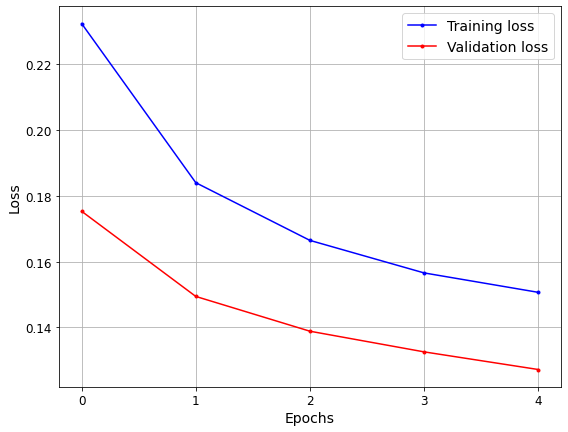

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, len(history.epoch), 0.1, 0.15])
    # plt.axis([1, len(history.epoch), min(history.history["val_loss"]), max(history.history["val_loss"])])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

plot_learning_curves(history.history["loss"], history.history["val_loss"])

##3.3 Forecasting diario en conjunto de prueba
A continuación, veremos el resultado del entrenamiento realizado primero crearemos una función que nos permitirá obtener algunas métricas de las predicciones realizadas y, a su vez, obtenemos las predicciones para posteriormente graficarlas. 

In [ ]:
def forecast_model(model, data):
    forecast = np.zeros((len(data)-n_steps_in_d,1))
    for time in tqdm(range(0,len(data) - (n_steps_in_d), n_steps_out_d), desc = 'tqdm() Progress Bar'):
        prediction = model.predict(np.array(data[time:time+n_steps_in_d]).reshape((1,-1,1)))[0]
        forecast[time:time+n_steps_out_d] = prediction
    forecast = forecast.reshape(-1,1)
    
    mse = np.sqrt(mean_squared_error(scaler.inverse_transform(forecast), scaler.inverse_transform((data[n_steps_in_d::]))))
    mae = mean_absolute_error(scaler.inverse_transform(forecast), scaler.inverse_transform((data[n_steps_in_d::])))
    r2 = r2_score(scaler.inverse_transform(forecast), scaler.inverse_transform((data[n_steps_in_d::])))
    
    print('Root mean square error: ', mse)
    print('Mean absolute error: ', mae)
    print('R-Squared: ', r2)
    
    return forecast

### Métricas de Entrenamiento

In [ ]:
forecast_train = forecast_model(model_d, x_train)

tqdm() Progress Bar: 100%|██████████| 5103/5103 [06:26<00:00, 13.22it/s]

Root mean square error:  113.0277729103626
Mean absolute error:  67.60543905553838
R-Squared:  0.8341329268484502


### Métricas de Validación

In [ ]:
forecast_validation = forecast_model(model_d, x_valid)
model_d.evaluate(validation_set)

tqdm() Progress Bar: 100%|██████████| 1088/1088 [01:14<00:00, 14.66it/s]


Root mean square error:  103.20335050855094
Mean absolute error:  62.512472274807585
R-Squared:  0.8516360930709834
204/204 [==============================] - 10s 47ms/step - loss: 0.1272 - mae: 0.2108


[0.12719817459583282, 0.21075156331062317]

### Métricas de Testing

In [ ]:
forecast_testing = forecast_model(model_d, x_test)
model_d.evaluate(test_set)

tqdm() Progress Bar: 100%|██████████| 1088/1088 [01:23<00:00, 12.96it/s]


Root mean square error:  108.93617637418008
Mean absolute error:  65.8006135309339
R-Squared:  0.8443262211365083
204/204 [==============================] - 13s 62ms/step - loss: 0.1424 - mae: 0.2225


[0.14240553975105286, 0.22251839935779572]

Text(0.5, 1.0, 'Daily forecasting of irradiance in 500 hours')

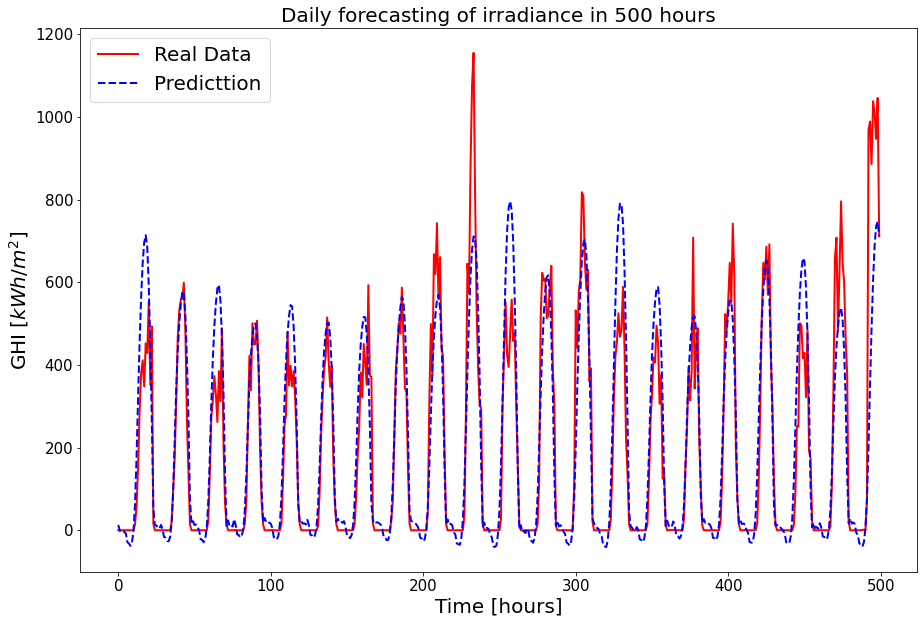

In [ ]:
start=500
end=1000


plt.figure(figsize=(15,10))
plt.plot(scaler.inverse_transform(x_test[n_steps_in_d::])[start:end] , 'r', label='Real Data', linewidth=2)
plt.plot(scaler.inverse_transform(forecast_testing)[start:end], 'b--', label='Predicttion', linewidth=2)
plt.legend(loc='best', fontsize=20)
plt.xlabel('Time [hours]', fontsize=20)
plt.ylabel('GHI $[kWh/m^2]$', fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.title('Daily forecasting of irradiance in {} hours'.format(end-start), fontsize=20)

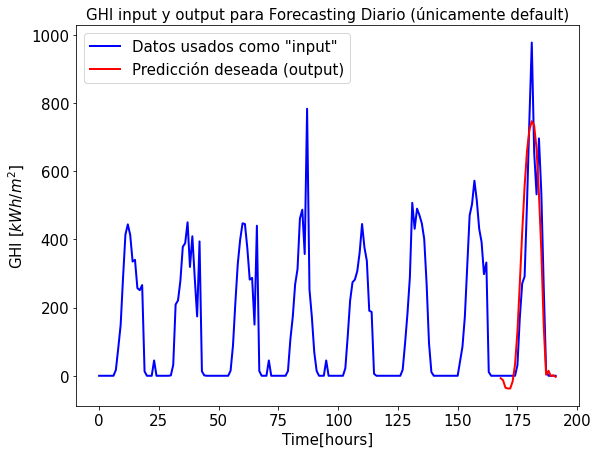

In [ ]:

plt.figure()
plt.rcParams['figure.figsize'] = (9, 7)
start = 5
start = 24*start

plt.plot(scaler.inverse_transform(x_test[start:start+n_steps_in_d+n_steps_out_d]),'b', label='Datos usados como "input"', linewidth=2)
plt.plot([i for i in range(n_steps_in_d,n_steps_in_d+n_steps_out_d)],scaler.inverse_transform(forecast_testing)[start+n_steps_in_d:start+n_steps_in_d+n_steps_out_d],'r', label='Predicción deseada (output)', linewidth=2)
plt.legend(loc='best', fontsize=15)
plt.xlabel("Time[hours]", fontsize=15)
plt.xticks(size=15)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=15)
plt.title('GHI input y output para Forecasting Diario (únicamente default)', fontsize=15)
plt.yticks(size=15)
# plt.savefig('/figure.pdf', format='pdf', dpi=300)
plt.show()

<a name="retos"></a>
#4. Retos
1. Entrenar diferentes arquitecturas (número de neuronas, días de entrada).
2. Construir un modelo para predecir la irradiación de una semana.
3. Probar con más datos (recuede que usamos 1 años para entrenamiento, 1 año para prueba, y un año para validación).
